# **Lung Cancer Classification from Chest CT-Scans**
# Using Convolutional Neural Networks

# Project Overview:
This notebook shows the development of a deep learning model to automate classfication of lung cancer subtypes from CT scan images.
The goal is to understand and predict the major histological types of lung cancer.

**Target Classes:**
- **Adenocarcinoma (ADC)**(~40% of cases).
- **Large Cell Carcinoma (LCC)** (~10% of cases)
- **Squamous Cell Carcinoma (SCC)**(~25-30% of cases)
- **Normal**: Healthy lung tissue

## Clinical Significance
Histological Classification is crucial for three mains reasons:

    - Each subtypes responds differently to treatments
    
    - Prognosis varies as survival varies between subtypes
    
    - Treatment planning such as immunotherapy elegibility depends on the cancer type
    
    - Automated screening could help radiologists identify early stages of lung-cancer.


## Dataset:
- **Train**: 613 images (Adeno: 195, Squamous: 155, Normal: 148, Large Cell: 115)
- **Valid**: 72 images
- **Test**: 315 images

*However I applied data augmentation*

## Notebook Architecture:
Loads and visualizes data (I) ->  applies data augmentation (II) ->  Builds EfficientNetB0 model (III) -> trains (IV) -> performance analytics (V) -> Confusion matric and metrics (VI)

# I.I Import Libraries

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import warnings

keras.backend.clear_session()
tf.keras.backend.clear_session()

warnings.filterwarnings("ignore")


# I.II Configuration

In [2]:
train_path = r"C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\train"
val_path = r"C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\valid"
test_path = r"C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\test"

for path_name, path in [("Train", train_path), ("Valid", val_path), ("Test", test_path)]:
    if os.path.exists(path):
        print(f"{path_name} path exists: {path}")
    else:
        print(f"{path_name} path wasn't found: {path}")

Train path exists: C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\train
Valid path exists: C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\valid
Test path exists: C:\Users\tdech\Desktop\Coding_projects\Data_lung_cancer\test


# I.III Loading Data

In [3]:
def GetDatasetSize(path):
    num_of_image = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            num_of_image[folder] = len(os.listdir(folder_path))
    return num_of_image

train_set = GetDatasetSize(train_path)
val_set = GetDatasetSize(val_path)
test_set = GetDatasetSize(test_path)

total_train = sum(train_set.values())
total_val = sum(val_set.values())
total_test = sum(test_set.values())


print(f"Train: {total_train} images")
print(f"Valid: {total_val} images")
print(f"test: {total_test} images")
print(f"TOTAL: {total_train + total_val + total_test} images")

Train: 613 images
Valid: 72 images
test: 315 images
TOTAL: 1000 images


---
# II.I Data Visualization

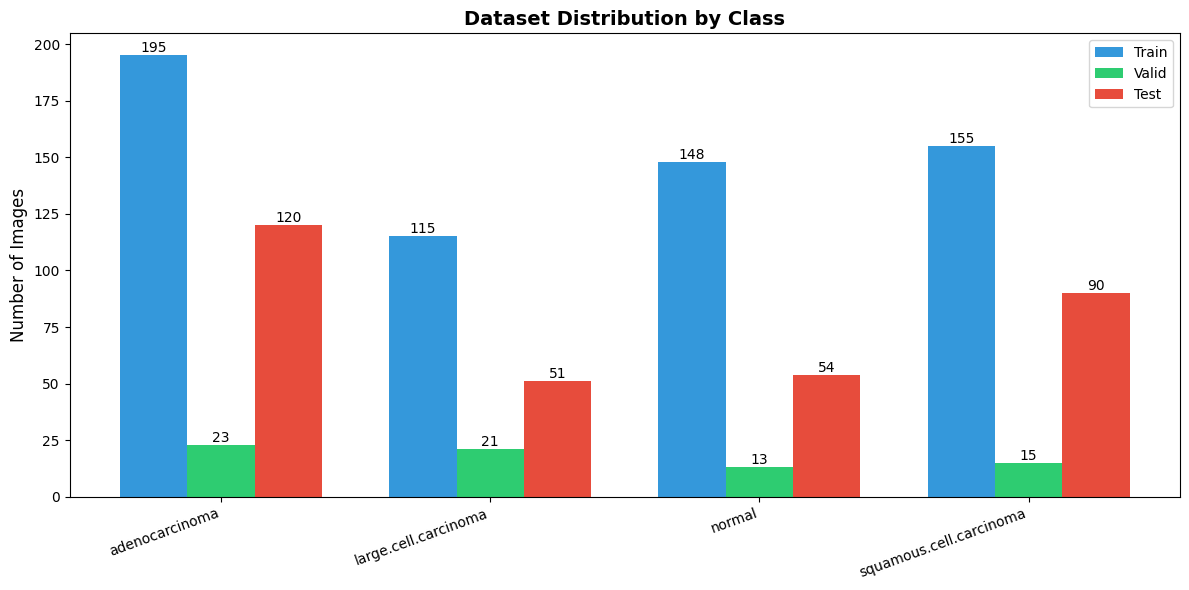

In [4]:
labels = ['adenocarcinoma', 'large.cell.carcinoma', 'normal', 'squamous.cell.carcinoma']


train_counts = [195, 115, 148, 155]
val_counts = [23, 21, 13, 15]
test_counts = [120, 51, 54, 90]

x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width, train_counts, width, label='Train', color='#3498db')
rects2 = ax.bar(x, val_counts, width, label='Valid', color='#2ecc71')
rects3 = ax.bar(x + width, test_counts, width, label='Test', color='#e74c3c')

ax.set_ylabel('Number of Images', fontsize=12)
ax.set_title('Dataset Distribution by Class', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=20, ha='right')
ax.legend()
ax.bar_label(rects1)
ax.bar_label(rects2)
ax.bar_label(rects3)

plt.tight_layout()
plt.show()



---
# III.I Data Augmentation

# Note on Augmentation Parameters

The augmentation parameters in this notebook were origionaly agressive, wich had negative consequences on the results. 

Indeed, **rotation_range** of 20° was unrealistic as medical scans have a constant orientation (however the new rotation_range of 10° accounts for possibe human error).

**width_shift_range=0.2** and **height_shift_range=0.2** was quite large and could shift tumors out of frame

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,           
    horizontal_flip=True,       
    fill_mode='nearest',         
    zoom_range=0.1,              
    shear_range=0.1,            
    width_shift_range=0.1,      
    height_shift_range=0.1,     
    rotation_range=10         
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [6]:
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size=5,               
    target_size=(350, 350),    
    class_mode='categorical'    
)

print("\nTraining Data Info:")
print(f"total images: {train_data.samples}")
print(f"classes: {list(train_data.class_indices.keys())}")
print(f"xclass indices: {train_data.class_indices}")

class_names = list(train_data.class_indices.keys())

Found 613 images belonging to 4 classes.

Training Data Info:
total images: 613
classes: ['adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib', 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa', 'normal', 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa']
xclass indices: {'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0, 'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 1, 'normal': 2, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 3}


In [7]:
val_data = val_datagen.flow_from_directory(
    val_path,
    batch_size=32,
    target_size=(350, 350),
    class_mode='categorical'
)



Found 72 images belonging to 4 classes.


In [8]:
test_data = test_datagen.flow_from_directory(
    test_path,
    batch_size=8,
    target_size=(350, 350),
    class_mode='categorical',
    shuffle=False             
)

print(f"\n Test data loaded: {test_data.samples} images")


Found 315 images belonging to 4 classes.

 Test data loaded: 315 images


---
# Sample CT-Scan Images

**Visualizing sample images helps us:**
Verify data loading, assess augmentation effects and check image quality

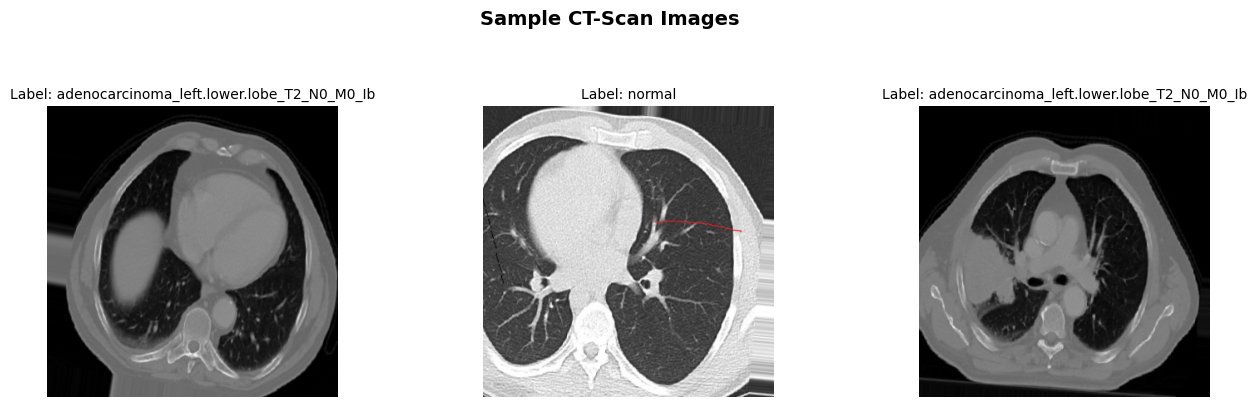

In [9]:
def plot_sample_images(images, labels, class_indices):
    class_labels = list(class_indices.keys())
    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    fig.subplots_adjust(wspace=0.5)
    
    for i in range(len(images)):
        axs[i].imshow(images[i])
        label_idx = np.argmax(labels[i])
        axs[i].set_title(f"Label: {class_labels[label_idx]}", fontsize=10)
        axs[i].axis('off')
    
    plt.suptitle('Sample CT-Scan Images', fontsize=14, fontweight='bold')
    plt.show()


sample_images, sample_labels = next(train_data)
plot_sample_images(sample_images[:3], sample_labels[:3], train_data.class_indices)


In [10]:
class_weights_array = compute_class_weight(
    'balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)

class_weights = dict(enumerate(class_weights_array))

for idx, weight in class_weights.items():
    print(f"   {class_names[idx][:35]:35s}: {weight:.4f}")



   adenocarcinoma_left.lower.lobe_T2_N: 0.7859
   large.cell.carcinoma_left.hilum_T2_: 1.3326
   normal                             : 1.0355
   squamous.cell.carcinoma_left.hilum_: 0.9887


---
# **EfficientNetB0 Model**
Using this convolutional neural network model that is trained on more than a million images from the ImageNet database.

In [11]:


base_model = EfficientNetB0(
    input_shape=(350, 350, 3),
    include_top=False,             
    weights='imagenet'             
)

base_model.trainable = True

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=0.4)(x)       
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)  
model = tf.keras.models.Model(inputs=base_model.input, outputs=outputs)

In [12]:
learning_rate = 9e-4 

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)


## III.I Training Callbacks Setup


**1. ModelCheckpoint**
 Automatically save the model whenever validation accuracy improves (to retrieve the best model at the end).

**2. EarlyStopping**
 Stop training when validation loss stops improving for 10 consecutive epochs (to avoid overfitting).

**3. ReduceLROnPlateau**
Reduce learning rate when validation loss plateaus (to avoid overshooting).



In [13]:

mc = ModelCheckpoint(
    filepath="best_lung_cancer_model.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=9,                     
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,                 
    patience=2,
    min_delta=0.001,
    mode='max',
    verbose=1
)

callbacks = [mc, early_stopping, reduce_lr]


## IV.I Train Model

### Training Process

The model will:

--> **Forward pass** 

--> **Calculate loss**(comparing predictions to true results) 

--> **Backward pass** (backpropagation) 

-->**Update weights** ( to reduce loss)

--> **Validate** (test model on validation set after each epoch) 

--> **Apply callbacks**

In [14]:

steps_per_epoch = train_data.samples // train_data.batch_size
validation_steps = val_data.samples // val_data.batch_size


history = model.fit(
    train_data,
    steps_per_epoch=steps_per_epoch,
    epochs=32,
    validation_data=val_data,
    validation_steps=validation_steps,
    callbacks=callbacks,
    class_weight=class_weights,    
    verbose=1
)


Epoch 1/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4780 - loss: 1.1368
Epoch 1: val_accuracy improved from None to 0.20312, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - accuracy: 0.5559 - loss: 1.0028 - val_accuracy: 0.2031 - val_loss: 2.6838 - learning_rate: 9.0000e-04
Epoch 2/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 4:10 2s/step - accuracy: 0.6000 - loss: 0.6844
Epoch 2: val_accuracy did not improve from 0.20312
122/122 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.6000 - loss: 0.6844 - val_accuracy: 0.1562 - val_loss: 3.9414 - learning_rate: 9.0000e-04
Epoch 3/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6572 - loss: 0.8857
Epoch 3: val_accuracy did not improve from 0.20312

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00026999999536201356.
122/122 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.6776 - loss: 0.7716 - val_accuracy: 0.1875 - val_loss: 2.8494 - learning_rate: 9.0000e-04
Epoch 4/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 4:24 2s/step - accuracy: 0.8000 - loss: 0.6834
Epoch 4: val_accuracy did not improve from 0.20312
122/122 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - accuracy: 0.8000 - loss: 0.6

122/122 ━━━━━━━━━━━━━━━━━━━━ 256s 2s/step - accuracy: 0.7796 - loss: 0.5149 - val_accuracy: 0.2344 - val_loss: 1.9631 - learning_rate: 2.7000e-04
Epoch 6/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:41 1s/step - accuracy: 1.0000 - loss: 0.1648
Epoch 6: val_accuracy improved from 0.23438 to 0.25000, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 1.0000 - loss: 0.1648 - val_accuracy: 0.2500 - val_loss: 1.8544 - learning_rate: 2.7000e-04
Epoch 7/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8721 - loss: 0.3553
Epoch 7: val_accuracy improved from 0.25000 to 0.26562, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.8783 - loss: 0.3474 - val_accuracy: 0.2656 - val_loss: 2.1157 - learning_rate: 2.7000e-04
Epoch 8/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 2:04 1s/step - accuracy: 1.0000 - loss: 0.0920
Epoch 8: val_accuracy improved from 0.26562 to 0.31250, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 1.0000 - loss: 0.0920 - val_accuracy: 0.3125 - val_loss: 1.9866 - learning_rate: 2.7000e-04
Epoch 9/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 988ms/step - accuracy: 0.8939 - loss: 0.2404
Epoch 9: val_accuracy did not improve from 0.31250
122/122 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.8931 - loss: 0.2448 - val_accuracy: 0.1719 - val_loss: 1.9259 - learning_rate: 2.7000e-04
Epoch 10/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:53 942ms/step - accuracy: 1.0000 - loss: 0.1346
Epoch 10: val_accuracy did not improve from 0.31250

Epoch 10: ReduceLROnPlateau reducing learning rate to 8.099999686237424e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 0.1346 - val_accuracy: 0.1875 - val_loss: 1.8062 - learning_rate: 2.7000e-04
Epoch 11/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 962ms/step - accuracy: 0.9317 - loss: 0.1797
Epoch 11: val_accuracy improved from 0.31250 to 0.37500, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 121s 992ms/step - accuracy: 0.9408 - loss: 0.1794 - val_accuracy: 0.3750 - val_loss: 2.0341 - learning_rate: 8.1000e-05
Epoch 12/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 979ms/step - accuracy: 1.0000 - loss: 0.0817
Epoch 12: val_accuracy improved from 0.37500 to 0.39062, saving model to best_lung_cancer_model.h5


122/122 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 1.0000 - loss: 0.0817 - val_accuracy: 0.3906 - val_loss: 2.1059 - learning_rate: 8.1000e-05
Epoch 13/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 961ms/step - accuracy: 0.9252 - loss: 0.1680
Epoch 13: val_accuracy did not improve from 0.39062
122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 981ms/step - accuracy: 0.9309 - loss: 0.1509 - val_accuracy: 0.1875 - val_loss: 3.5054 - learning_rate: 8.1000e-05
Epoch 14/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:56 966ms/step - accuracy: 1.0000 - loss: 0.0040
Epoch 14: val_accuracy did not improve from 0.39062

Epoch 14: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-05.
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 1.0000 - loss: 0.0040 - val_accuracy: 0.1719 - val_loss: 3.7677 - learning_rate: 8.1000e-05
Epoch 15/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.9475 - loss: 0.1454
Epoch 15: val_accuracy did not improve from 0.39062
122/122 ━━━━━━━━━━━━━━━━━━━━ 118s 965ms/step - accuracy:

122/122 ━━━━━━━━━━━━━━━━━━━━ 118s 963ms/step - accuracy: 0.9523 - loss: 0.1295 - val_accuracy: 0.9375 - val_loss: 0.2156 - learning_rate: 7.2900e-06
Epoch 18/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:53 936ms/step - accuracy: 1.0000 - loss: 0.1310
Epoch 18: val_accuracy did not improve from 0.93750
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 1.0000 - loss: 0.1310 - val_accuracy: 0.9219 - val_loss: 0.2919 - learning_rate: 7.2900e-06
Epoch 19/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 942ms/step - accuracy: 0.9758 - loss: 0.0981
Epoch 19: val_accuracy did not improve from 0.93750

Epoch 19: ReduceLROnPlateau reducing learning rate to 2.186999927289435e-06.
122/122 ━━━━━━━━━━━━━━━━━━━━ 118s 962ms/step - accuracy: 0.9737 - loss: 0.1042 - val_accuracy: 0.7031 - val_loss: 0.7029 - learning_rate: 7.2900e-06
Epoch 20/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:54 947ms/step - accuracy: 1.0000 - loss: 0.0419
Epoch 20: val_accuracy did not improve from 0.93750
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accurac

122/122 ━━━━━━━━━━━━━━━━━━━━ 118s 965ms/step - accuracy: 0.9556 - loss: 0.1116 - val_accuracy: 0.9531 - val_loss: 0.2128 - learning_rate: 6.5610e-07
Epoch 24/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:53 941ms/step - accuracy: 1.0000 - loss: 0.0062
Epoch 24: val_accuracy did not improve from 0.95312
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 1.0000 - loss: 0.0062 - val_accuracy: 0.9531 - val_loss: 0.2138 - learning_rate: 6.5610e-07
Epoch 25/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 944ms/step - accuracy: 0.9724 - loss: 0.1061
Epoch 25: val_accuracy did not improve from 0.95312

Epoch 25: ReduceLROnPlateau reducing learning rate to 1.9682997844938655e-07.
122/122 ━━━━━━━━━━━━━━━━━━━━ 118s 965ms/step - accuracy: 0.9720 - loss: 0.0955 - val_accuracy: 0.9531 - val_loss: 0.2094 - learning_rate: 6.5610e-07
Epoch 26/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:53 936ms/step - accuracy: 0.8000 - loss: 0.4280
Epoch 26: val_accuracy did not improve from 0.95312
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accura

122/122 ━━━━━━━━━━━━━━━━━━━━ 120s 981ms/step - accuracy: 0.9507 - loss: 0.1326 - val_accuracy: 0.9688 - val_loss: 0.1075 - learning_rate: 1.9683e-07
Epoch 28/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:58 978ms/step - accuracy: 1.0000 - loss: 0.0401
Epoch 28: val_accuracy did not improve from 0.96875
122/122 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 1.0000 - loss: 0.0401 - val_accuracy: 0.9531 - val_loss: 0.2003 - learning_rate: 1.9683e-07
Epoch 29/40
122/122 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.9566 - loss: 0.1242
Epoch 29: val_accuracy did not improve from 0.96875

Epoch 29: ReduceLROnPlateau reducing learning rate to 5.9048991829513396e-08.
122/122 ━━━━━━━━━━━━━━━━━━━━ 119s 972ms/step - accuracy: 0.9508 - loss: 0.1212 - val_accuracy: 0.9531 - val_loss: 0.2041 - learning_rate: 1.9683e-07
Epoch 30/40
  1/122 ━━━━━━━━━━━━━━━━━━━━ 1:16 630ms/step - accuracy: 1.0000 - loss: 0.0067
Epoch 30: val_accuracy did not improve from 0.96875
122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accura

## V.I Training History Visualization

### To understand the **Accuracy Plot** look for:

**Both curves are rising**, then the model is learning.
**Gap between curves** is natural as normal-training always performs better.
**Validation plateaus continuously rising** is a sign of overfitting.

**Accuracy Plot (Left)**:
- **Both curves rising**: Model is learning successfully
- **Gap between curves**: Normal—training always performs slightly better
- **Validation plateaus while training continues rising**: Sign of overfitting

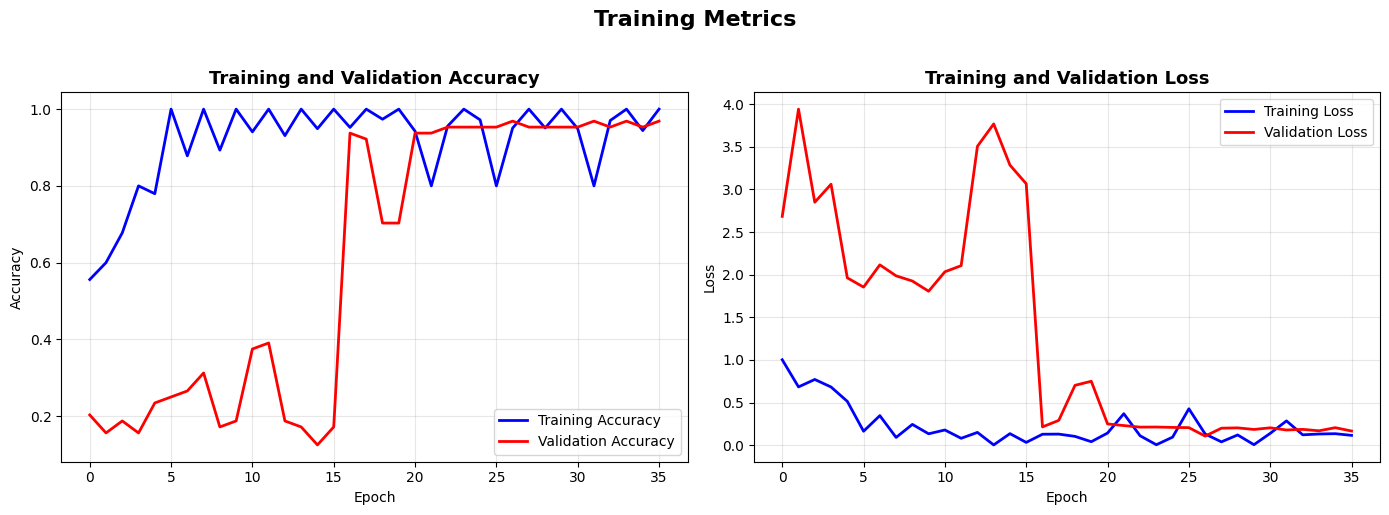

In [15]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(accuracy))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


ax1.plot(epochs_range, accuracy, 'b-', label='Training Accuracy', linewidth=2)
ax1.plot(epochs_range, val_accuracy, 'r-', label='Validation Accuracy', linewidth=2)
ax1.set_title('Training and Validation Accuracy', fontsize=13, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)


ax2.plot(epochs_range, loss, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs_range, val_loss, 'r-', label='Validation Loss', linewidth=2)
ax2.set_title('Training and Validation Loss', fontsize=13, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.suptitle('Training Metrics', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()



## VI.I Model Evaluation on Test Set

# Evaluation of Model (on data model hasn't seen)

**Test Accuracy**: Overall percentage of correct predictions

**Test Loss**: How confident are the predictions.



In [16]:

best_model = load_model("best_lung_cancer_model.h5")

test_loss, test_accuracy = best_model.evaluate(test_data, verbose=0)

print(f"\n TEST RESULTS:")
print(f" Accuracy: {test_accuracy*100:.2f}%")
print(f"  Loss: {test_loss:.4f}")




 TEST RESULTS:
 Accuracy: 89.21%
  Loss: 0.3251


# Classification Report and Class Performance

**Precision**

- High precision means there are few false positives

**Recall**

- Of all the cases of certain cancer type, what percentage did we detect?

**F1-score** 

- Balance between false positives and false negatives. This metric is crucial to understand when the model is wrong and how often does it happen: critical to avoid unneccasrary treatments.


In [17]:

test_data.reset()
y_pred_prob = best_model.predict(test_data, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_data.classes

test_class_names = list(test_data.class_indices.keys())


print(classification_report(
    y_true,
    y_pred,
    target_names=test_class_names,
    digits=4
))



40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 415ms/step
                         precision    recall  f1-score   support

         adenocarcinoma     0.9700    0.8083    0.8818       120
   large.cell.carcinoma     0.6456    1.0000    0.7846        51
                 normal     1.0000    0.9815    0.9907        54
squamous.cell.carcinoma     0.9639    0.8889    0.9249        90

               accuracy                         0.8921       315
              macro avg     0.8949    0.9197    0.8955       315
           weighted avg     0.9209    0.8921    0.8970       315



# Confusion Matrix Analysis

**Rows**: Represent the actual cancer types

**Columns**: Predicited labels

**Diagongal**: Correct predictions

**Off Diagonal**: Incorrect predictions

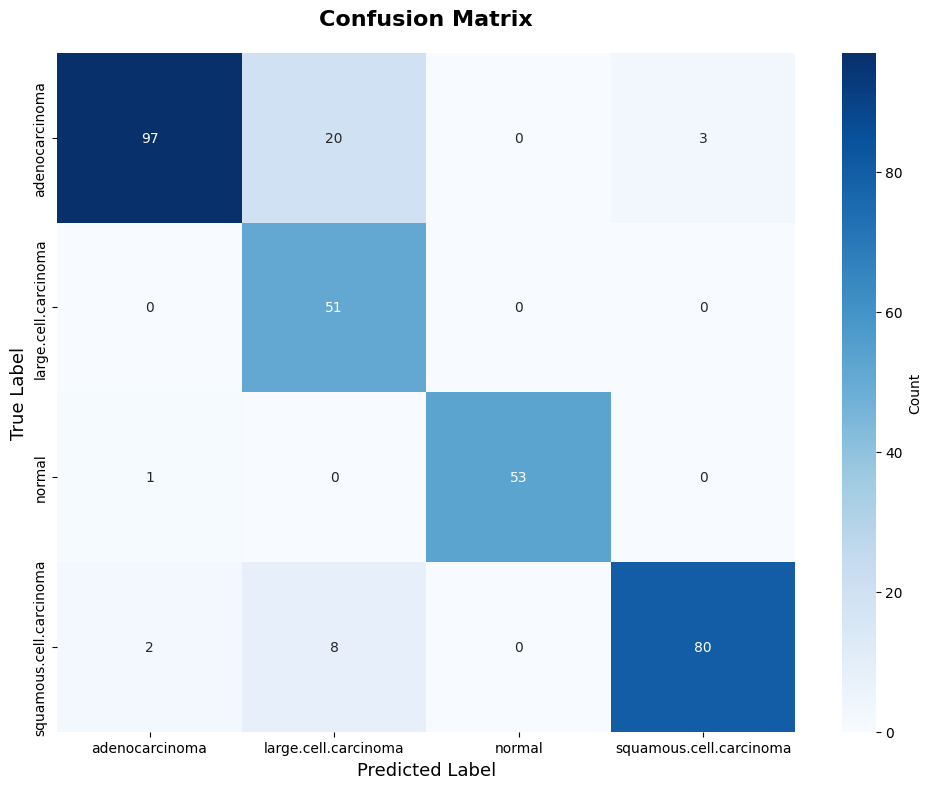

In [18]:

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=test_class_names,
    yticklabels=test_class_names,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=13)
plt.xlabel('Predicted Label', fontsize=13)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



In [19]:


for i, class_name in enumerate(test_class_names):
    if i < len(cm):
        correct = cm[i, i]
        total = cm[i, :].sum()
        accuracy = (correct / total * 100) if total > 0 else 0
        

        
        print(f"{class_name:30s}: {correct:3d}/{total:3d} ({accuracy:5.1f}%)")



adenocarcinoma                :  97/120 ( 80.8%)
large.cell.carcinoma          :  51/ 51 (100.0%)
normal                        :  53/ 54 ( 98.1%)
squamous.cell.carcinoma       :  80/ 90 ( 88.9%)


In [20]:


final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"\nRESULTS:")
print(f"   Training Accuracy:   {final_train_acc*100:.2f}%")
print(f"   Validation Accuracy: {final_val_acc*100:.2f}%")
print(f"   Test Accuracy:       {test_accuracy*100:.2f}%")




RESULTS:
   Training Accuracy:   100.00%
   Validation Accuracy: 96.88%
   Test Accuracy:       89.21%


## Results and Implications

### Model Performance Overview

**Test Accuracy**: 89.21%

**Training stopped at epoch**: 36/40


# Implication: Treatment differences

**ADC patients**: Should be tested for mutations before chemotherapy (possible access to targeted treatments wtih less side effects).

**SCC patients**: Avoid pemetrexed chemotherapy (as it is ineffective), often need gemcitabine.

**LCC patients**: Similar treatment to SCC

***For reference:*** Adenocarcinoma (= ADC)/ Large Cell Carcinoma (= LCC)/ Squamous Cell Carcinoma (= SCC)

This is why the model's ability to distinguish ADC from SCC/LCC is more clinically important than distinguishing SCC from LCC.